In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline

Read the files

In [2]:
#read csv file
portfolio = pd.read_csv('../../../Data/Portfolio.csv',parse_dates=True,index_col='T')


In [3]:
#tranform this into a matrix
X = portfolio.as_matrix()

#the last column is the target
Y = X[:,-1]

#create the design matrix2
X = X[:,0:-1]

index_name = portfolio.columns[:-1]

Set up the ridge regression (fit_intercept=True, in order to allow normalization to be true)

In [4]:
#setting up the model
Alpha = 0.2
ridge_model = linear_model.Ridge(fit_intercept=True, alpha=Alpha,copy_X=True,normalize=True)
ridge_model.fit(X,Y)

ols_model = linear_model.LinearRegression(fit_intercept=True)
ols_model.fit(X,Y)



/Users/jandespiegeleer/anaconda/lib/python3.5/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [5]:
print('RSquared OLS')
print(ols_model.score(X,Y))
print('RSquared Ridge')
print(ridge_model.score(X,Y))

RSquared OLS
0.5721537153344336
RSquared Ridge
0.5600881401647178


In [6]:
#using the function to estimate the portfolio return
X_test = np.array([0.01 , 0.01, 0.02 , -0.05 , 0.0, 0.01,0.07])
X_test = X_test.reshape((1,len(X_test)))

Y_test = ols_model.predict(X_test)
print(Y_test)

[0.04550743]


Gross Exposure OLS :205.76

Gross Exposure Ridge :128.64



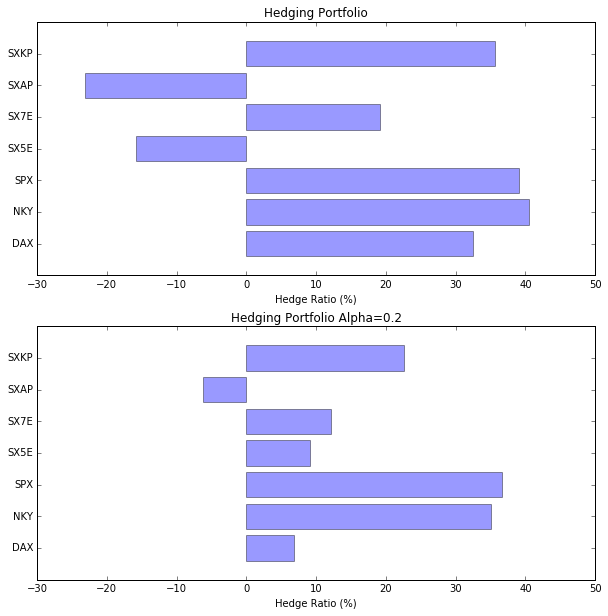

In [7]:
#OLS
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
y_pos = np.arange(len(index_name))
hedge_ols = ols_model.coef_
plt.barh(bottom=y_pos, width=hedge_ols*100, align='center', alpha=0.4)
plt.yticks(y_pos, index_name)
plt.xlabel('Hedge Ratio (%)')
plt.title('Hedging Portfolio')
xmin, xmax = plt.xlim() 
print('Gross Exposure OLS :{d:0.2f}\n'.format(d=100*np.sum(np.abs(hedge_ols))))
#Ridge Regression
plt.subplot(2,1,2)
hedge_ridge = ridge_model.coef_
plt.barh(bottom=y_pos, width=hedge_ridge*100, align='center', alpha=0.4)
plt.yticks(y_pos, index_name)
plt.xlabel('Hedge Ratio (%)')
plt.title('Hedging Portfolio Alpha='+ str(Alpha))
plt.xlim([xmin,xmax])
print('Gross Exposure Ridge :{d:0.2f}\n'.format(d=100*np.sum(np.abs(hedge_ridge))))

Study the impact of the ridge regression on the weights

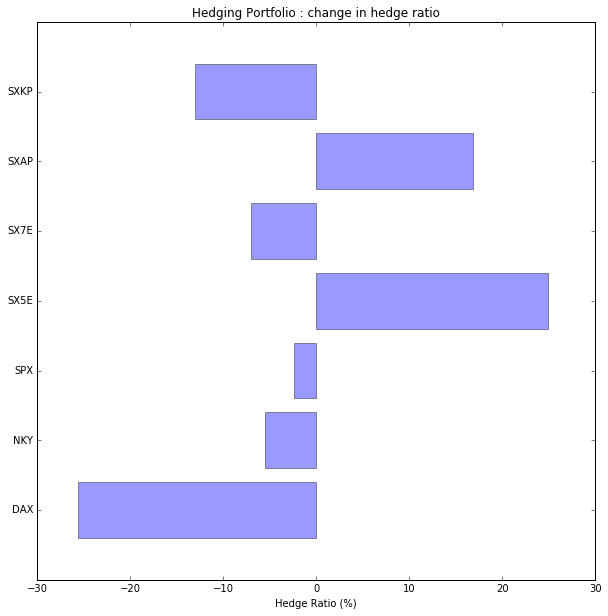

In [8]:
plt.figure(figsize=(10,10))
plt.barh(bottom=y_pos, width=(hedge_ridge-hedge_ols)*100, align='center', alpha=0.4)
plt.yticks(y_pos, index_name)
plt.xlabel('Hedge Ratio (%)')
plt.title('Hedging Portfolio : change in hedge ratio');

For different values of Alpha

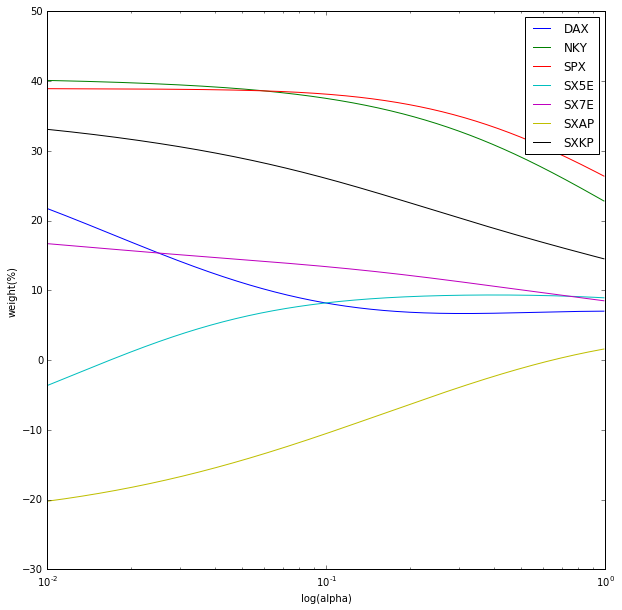

In [9]:
alpha = np.power(10,np.arange(-2,0,0.005))
weights = np.zeros((len(alpha),len(index_name)),dtype=float)

for i in np.arange(0,len(alpha)):
    ridge_model = linear_model.Ridge(fit_intercept=True, alpha=alpha[i],copy_X=True,normalize=True)
    ridge_model.fit(X,Y)
    weights[i,:]= ridge_model.coef_

plt.figure(figsize=(10,10))    
for i in np.arange(0,len(index_name)):
    plt.semilogx(alpha[:],weights[:,i]*100,label=index_name[i])

plt.xlabel('log(alpha)')
plt.ylabel('weight(%)')
plt.legend(loc="upper right");
    

Using cross validation to find the optimal value of the ridge factor.

In [10]:
# use cross validation using 10 Fold cross validation
Ridge=linear_model.RidgeCV(alphas=alpha,fit_intercept=True,normalize=True,cv=10)
Ridge.fit(X,Y)
print('Optimal Value for Alpha:{v:0.4f}'.format(v=Ridge.alpha_))
print(Ridge.coef_)

Optimal Value for Alpha:0.5248
[ 0.06837724  0.28699529  0.31603679  0.09317992  0.09973526 -0.00919535
  0.17523091]


(-30.0, 50.0)

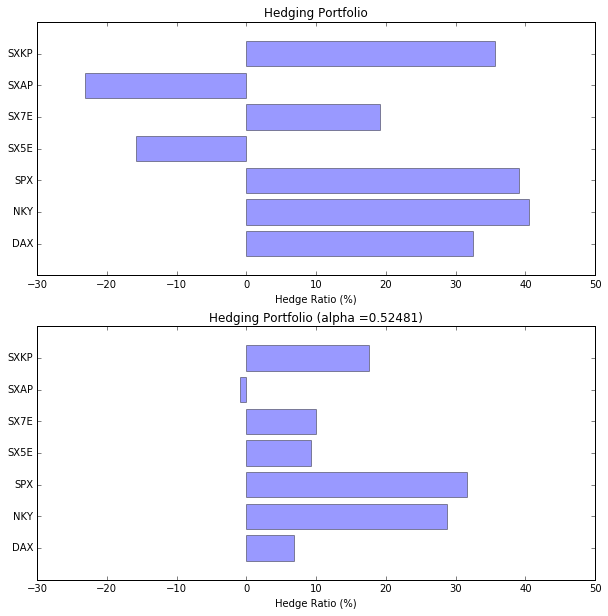

In [11]:
#calc with new alpha
ridge_model = linear_model.Ridge(fit_intercept=True, alpha=Ridge.alpha_,copy_X=True,normalize=True)
ridge_model.fit(X,Y)


#OLS
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
y_pos = np.arange(len(index_name))
hedge_ols = ols_model.coef_
plt.barh(bottom=y_pos, width=hedge_ols*100, align='center', alpha=0.4)
plt.yticks(y_pos, index_name)
plt.xlabel('Hedge Ratio (%)')
plt.title('Hedging Portfolio')
xmin, xmax = plt.xlim() 

#Optimal Ridge Regression
plt.subplot(2,1,2)
hedge_ridge = ridge_model.coef_
plt.barh(bottom=y_pos, width=ridge_model.coef_*100, align='center', alpha=0.4)
plt.yticks(y_pos, index_name)
plt.xlabel('Hedge Ratio (%)')
plt.title('Hedging Portfolio (alpha =%5.5f)' % Ridge.alpha_ )
plt.xlim([xmin,xmax])